#### 登入google帳戶

In [ ]:
import math
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import cv2
import os
import warnings
from google.colab import drive
drive.mount('/content/drive')
MAIN_DIR = '/content/drive/MyDrive/ourdata_v2/' #the main directory of this project

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

#### 測試照片

In [ ]:
#load a single image as a test 
from keras.preprocessing import image
test_image = image.load_img('/content/drive/MyDrive/ourdata_v2/test/paper/IMG_6922.jpg')
test_image

In [ ]:
#load image and transform to 3D array - image array shape is 384 x 512 pixels, colour channels = 3 (RGB)
img_array = image.img_to_array(test_image)
print(img_array.shape)
#process for transforming an image to an array -- one way to do it 
img_array = keras.applications.efficientnet.preprocess_input(img_array)
print(img_array.shape)

#### 對資料進行data argumentation

In [6]:
def center_crop(img):
  image_array = image.img_to_array(img)
  image_array = cv2.resize(image_array, (570,570))
  shape = image_array.shape # H, W, D
  left = int((shape[1]-380)/2)
  right = left + 380
  bottom = int((shape[0]-380)/2)
  top = bottom + 380
  return image_array[bottom:top, left:right]


def random_crop(img):
  image_array = image.img_to_array(img)
  image_array = cv2.resize(image_array, (570,570))
  shape = image_array.shape
  left = np.random.randint(0, shape[1]-380)
  right = left + 380
  bottom = np.random.randint(0, shape[0]-380)
  top = bottom + 380
  return image_array[bottom:top, left:right]

#隨機翻轉或擷取，且照片被整理為(380,380,3)
def center_process_img(img):
  cropped = center_crop(img)
  if np.random.rand() > 0.5:
    return np.flip(cropped, axis=np.random.randint(0, 2))
  else:
    return cropped
    
def random_process_img(img):
  cropped = random_crop(img)
  if np.random.rand() > 0.5:
    return np.flip(cropped, axis=np.random.randint(0, 2))
  else:
    return cropped


測試Augment images through random cropping & flipping

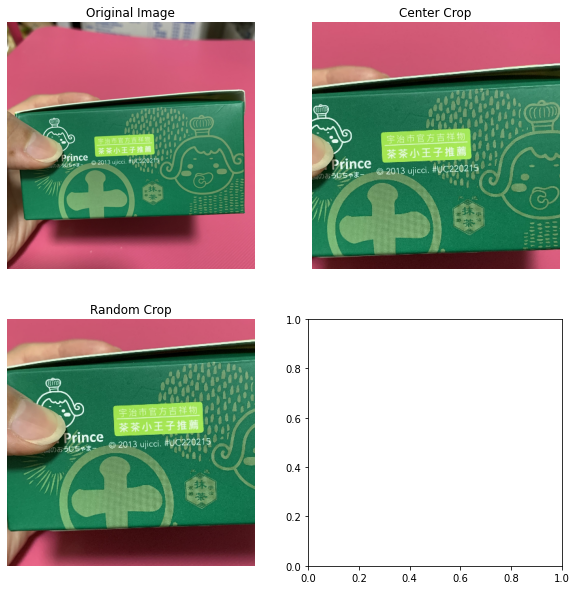

In [8]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
test_image = image.load_img('/content/drive/MyDrive/ourdata_v2/test/paper/IMG_6922.jpg')
center_cropped_test = image.array_to_img(center_crop(test_image))
random_cropped_test = image.array_to_img(random_crop(test_image))
# processed_test = image.array_to_img(keras.applications.efficientnet.preprocess_input(process_img(test_image)))
# print(keras.applications.efficientnet.preprocess_input(process_img(test_image)))

fig, ax = plt.subplots(2, 2)
fig.set_figheight(10)
fig.set_figwidth(10)

ax[0, 0].imshow(test_image)
ax[0, 0].set_title('Original Image')
ax[0, 0].axis('off')

ax[0, 1].imshow(center_cropped_test)
ax[0, 1].set_title('Center Crop')
ax[0, 1].axis('off')

ax[1, 0].imshow(random_cropped_test)
ax[1, 0].set_title('Random Crop')
ax[1, 0].axis('off')

plt.show()

#### 將訓練、驗證及測試資料匯進list裡面

In [ ]:
TEST_PATH = os.path.join(MAIN_DIR, 'test')
VALID_PATH = os.path.join(MAIN_DIR, 'valid')
TRAIN_PATH = os.path.join(MAIN_DIR, 'train')
print(TEST_PATH)
#create lists to write processed images into 
X_test_list = []
y_test_list = []

X_train_list = []
y_train_list = []

X_valid_list = []
y_valid_list = []

folder_names = ['paper', 'can', 'paper_container', 'plastic', 'trash']

#connect to test image folder
#X_test_list的處理
for folder in folder_names:             #folder為資料夾名稱
  FOLDER_PATH = os.path.join(TEST_PATH, folder)
  for im in os.listdir(FOLDER_PATH):
    #load image and transform to array
    img = image.load_img(os.path.join(TEST_PATH, folder, im))      #合併(TEST_PATH, folder, im)路徑載入圖片
    center_img_array = center_process_img(img)                      # 對照片進行center_process_img函數的翻轉或擷取
    center_processed_img = keras.applications.efficientnet.preprocess_input(center_img_array)   #對處理後的照片進行preprocess
    random_img_array = random_process_img(img)                      # 對照片進行random_process_img函數的翻轉或擷取
    random_processed_img = keras.applications.efficientnet.preprocess_input(random_img_array)   #對處理後的照片進行preprocess
    # 新增原始照片
    ori_img_array = image.img_to_array(img)
    ori_resize_img = cv2.resize(ori_img_array, (380,380))
    #append processed image to new list
    X_test_list.append(list(ori_resize_img))
    X_test_list.append(list(center_processed_img))
    X_test_list.append(list(random_processed_img))
    #append label of processed image to new list
    y_test_list += [folder]    # 只是為了計算下面有多少圖片已進來
    y_test_list += [folder]    # 只是為了計算下面有多少圖片已進來
    y_test_list += [folder]    # 只是為了計算下面有多少圖片已進來

    if len(y_test_list)%50 == 0:
      print(len(y_test_list), 'images loaded into test')

#connect to train image folder 
#X_train_list的處理
for folder in folder_names:
  FOLDER_PATH = os.path.join(TRAIN_PATH, folder)
  for im in os.listdir(FOLDER_PATH):
    #load image and transform to array
    img = image.load_img(os.path.join(TRAIN_PATH, folder, im))
    center_img_array = center_process_img(img)                      # 對照片進行center_process_img函數的翻轉或擷取
    center_processed_img = keras.applications.efficientnet.preprocess_input(center_img_array)   #對處理後的照片進行preprocess
    random_img_array = random_process_img(img)                      # 對照片進行random_process_img函數的翻轉或擷取
    random_processed_img = keras.applications.efficientnet.preprocess_input(random_img_array)   #對處理後的照片進行preproces
    # 新增原始照片
    ori_img_array = image.img_to_array(img)
    ori_resize_img = cv2.resize(ori_img_array, (380,380))
    #append processed image to new list
    X_train_list.append(list(ori_resize_img)) 
    X_train_list.append(list(center_processed_img))
    X_train_list.append(list(random_processed_img))
    #append label of processed image to new list 
    y_train_list += [folder] 
    y_train_list += [folder] 
    y_train_list += [folder] 

    if len(y_train_list)%50 == 0:
      print(len(y_train_list), 'images loaded into train')

for folder in folder_names:             #folder為資料夾名稱
  FOLDER_PATH = os.path.join(VALID_PATH, folder)
  for im in os.listdir(FOLDER_PATH):
    #load image and transform to array
    img = image.load_img(os.path.join(VALID_PATH, folder, im))      #合併(VALID_PATH, folder, im)路徑載入圖片
    center_img_array = center_process_img(img)                      # 對照片進行center_process_img函數的翻轉或擷取
    center_processed_img = keras.applications.efficientnet.preprocess_input(center_img_array)   #對處理後的照片進行preprocess
    random_img_array = random_process_img(img)                      # 對照片進行random_process_img函數的翻轉或擷取
    random_processed_img = keras.applications.efficientnet.preprocess_input(random_img_array)   #對處理後的照片進行preprocess
    # 新增原始照片
    ori_img_array = image.img_to_array(img)
    ori_resize_img = cv2.resize(ori_img_array, (380,380))
    #append processed image to new list
    X_valid_list.append(list(ori_resize_img))
    X_valid_list.append(list(center_processed_img))
    X_valid_list.append(list(random_processed_img))
    #append label of processed image to new list
    y_valid_list += [folder]    # 只是為了計算下面有多少圖片已進來
    y_valid_list += [folder]    # 只是為了計算下面有多少圖片已進來
    y_valid_list += [folder]    # 只是為了計算下面有多少圖片已進來

    if len(y_valid_list)%50 == 0:
      print(len(y_valid_list), 'images loaded into valid')

In [ ]:
ori_img = image.img_to_array(img)
img1 = cv2.resize(ori_img, (380,380))
print(img1.shape)

#### 將資料進行one hot encoding

In [ ]:
#transform X variables to floats
X_train = np.array(X_train_list).astype(np.float32)
X_test = np.array(X_test_list).astype(np.float32)
X_valid = np.array(X_valid_list).astype(np.float32)
print(X_train.shape)
print(X_test.shape)
print(X_valid.shape)
print(y_train_list)
print(len(y_train_list))
print(len(y_test_list))
print(len(y_valid_list))

In [ ]:
y_train = []
for i in range(len(y_train_list)):
  if y_train_list[i] == 'paper':
    y_train.append([1, 0, 0, 0, 0])
  elif y_train_list[i] == 'can':
    y_train.append([0, 1, 0, 0, 0])
  elif y_train_list[i] == 'paper_container':
    y_train.append([0, 0, 1, 0, 0])
  elif y_train_list[i] == 'plastic':
    y_train.append([0, 0, 0, 1, 0])
  elif y_train_list[i] == 'trash':
    y_train.append([0, 0, 0, 0, 1])

y_train = np.array(y_train)
print(y_train)
print(y_train.shape)


y_test = []
for i in range(len(y_test_list)):
  if y_test_list[i] == 'paper':
    y_test.append([1, 0, 0, 0, 0])
  elif y_test_list[i] == 'can':
    y_test.append([0, 1, 0, 0, 0])
  elif y_test_list[i] == 'paper_container':
    y_test.append([0, 0, 1, 0, 0])
  elif y_test_list[i] == 'plastic':
    y_test.append([0, 0, 0, 1, 0])
  elif y_test_list[i] == 'trash':
    y_test.append([0, 0, 0, 0, 1])

y_test = np.array(y_test)
print(y_test)
print(y_test.shape)


y_valid = []
for i in range(len(y_valid_list)):
  if y_valid_list[i] == 'paper':
    y_valid.append([1, 0, 0, 0, 0])
  elif y_valid_list[i] == 'can':
    y_valid.append([0, 1, 0, 0, 0])
  elif y_valid_list[i] == 'paper_container':
    y_valid.append([0, 0, 1, 0, 0])
  elif y_valid_list[i] == 'plastic':
    y_valid.append([0, 0, 0, 1, 0])
  elif y_valid_list[i] == 'trash':
    y_valid.append([0, 0, 0, 0, 1])

y_valid = np.array(y_valid)
print(y_valid)
print(y_valid.shape)

In [ ]:
#釋放資源
X_test_list, X_valid_list, X_train_list, y_test_list, y_valid_list, y_train_list = [], [], [], [], [], []

#### 建立模型

In [ ]:
base_model = keras.applications.EfficientNetB4(weights="imagenet", include_top=False, input_shape=(380, 380, 3))

In [ ]:
#freeze the base model 
base_model.trainable = False

#define the type of NN architecture - sequential model specifies a linear stack of layers 
model = keras.models.Sequential()

#add the pre-trained model
model.add(base_model)

#pool layer to prepare data as input into dense layer 
model.add(keras.layers.GlobalAveragePooling2D())
model.add(keras.layers.Dense(256, activation='relu'))
#batch normalization layer re-centers and re-scales the network - helps accelerate training
model.add(keras.layers.BatchNormalization())
#dropout layer - temporarily deactivates 20% of the nodes in the network each epoch to redistribute weights/help network concentrate on "weak" features and prevent overfitting
model.add(keras.layers.Dropout(0.2))
#flatten layer to single array for input into dense layer 
model.add(keras.layers.Flatten())
# prediction layer - 5 neurons = 5 category outputs, and softmax to normalize the output of the network to a probability distribution over the predicted output classes 
model.add(keras.layers.Dense(5, activation='sigmoid'))

In [ ]:
model.summary()

In [ ]:
#compile model, specify sparse categorical crossentropy for classification and evaluate accuracy
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

#### 使模型不overfiting

In [ ]:
# implementing a custom callback to stop training if we reach accuracy >0.999 because that indicates overfitting on this relatively small dataset
class OverfittingCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if logs.get('accuracy') > 0.999:
      self.model.stop_training = True
      print('Trying to prevent overfitting - stopping training')

In [ ]:
#TensorBoard - log model statistics
root_logdir = os.path.join(os.curdir, 'my_logs')

def get_run_logdir():
  import time
  run_id = time.strftime('run_%Y_%m_%d-%H_%M_%S')
  return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()

tensorboard_callback = keras.callbacks.TensorBoard(run_logdir, update_freq="epoch")

#### 訓練模型

In [ ]:
#train model for 40 epochs 
history = model.fit(X_train, y_train, epochs=20, validation_data = (X_valid, y_valid), callbacks=[keras.callbacks.EarlyStopping(patience=1, monitor='val_loss'), OverfittingCallback()])

In [ ]:
score = model.evaluate(X_test, y_test, verbose=0)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

In [ ]:
#unfreeze base model 
base_model.trainable = True
model.summary()

In [ ]:
history = model.fit(X_train, y_train, epochs=40, validation_data=(X_valid, y_valid), callbacks=[keras.callbacks.EarlyStopping(patience=1, monitor='val_loss'), OverfittingCallback()])

#### 測試資料結果呈現


In [ ]:
incorrect = dict()
x = np.where(y_test[0] == 1)[0][0]
print(len(X_test))
for idx, predictions in enumerate(model.predict(X_test)):       #predictions為各分類機率的陣列
  print(idx, predictions)
  if np.argmax(predictions) != np.where(y_test[idx] == 1)[0][0]:
    incorrect[idx] = {'Predicted': np.argmax(predictions), 'Actual': y_test[idx][0]}

incorrect_preds = pd.DataFrame.from_dict(incorrect, orient='index')

In [ ]:
incorrect_preds.reset_index()

In [ ]:
predicted_class=np.argmax(model.predict(X_test), axis = -1)
predicted_class
print(predicted_class)

In [ ]:
def class_convert_x(classess):
    pred=[]
    for i in classess:
        if i ==0:
            pred.append('paper')
        elif i==1:
            pred.append('can')
        elif i==2:
            pred.append('paper_container')
        elif i==3:
            pred.append('Plastic')
        elif i==4:
            pred.append('Trash')
    return pred


def class_convert_y(classess):
    pred=[]
    for i in classess:
        if i[0]==1:
            pred.append('paper')
        elif i[1]==1:
            pred.append('can')
        elif i[2]==1:
            pred.append('paper_container')
        elif i[3]==1:
            pred.append('Plastic')
        elif i[4]==1:
            pred.append('Trash')
    return pred

pred_class=class_convert_x(predicted_class)   #_x_test的預測結果
print(pred_class)
y_class=class_convert_y(y_test)         #y為答案
print(y_class)
print(len(pred_class), len(y_class))

In [ ]:
corr=0
false=0
for i in range(len(y_class)):
    if y_class[i]==pred_class[i]:
         corr=corr+1
    else:
        false=false+1
        
print("Correct:",corr)
print("False",false)
print(corr/(corr+false))

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sb
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Setting default fig size
size_ = (10,8)
cm=confusion_matrix(y_class,pred_class)

array_list = []
for i in range(5):
  sum_row = np.sum(cm[i])
  ratio_row = np.around(cm[i]/sum_row, decimals=2)
  array_list.append(ratio_row)
cm = np.array(array_list)

df_cm = pd.DataFrame(cm, range(cm.shape[0]), range(cm.shape[1]))
df_cm.columns = ['paper','can','paper_container','Plastic', 'Trash']
df_cm.index = ['paper','can','paper_container','Plastic', 'Trash']

fig = plt.subplots(figsize=size_)
sb.set(font_scale=1)
sb.heatmap(df_cm, annot=True, annot_kws={"size": 10}, cmap="viridis") # font size
plt.show()

#### 進行個別辨識

In [ ]:
image_path = '/content/drive/Shareddrives/recycle/test_images/AnyConv.com__IMG_0664.jpg'
image.load_img(image_path, target_size=(380, 380))

In [ ]:
def classify_image(my_image):
  custom_image = image.load_img(my_image, target_size=(380, 380))
  img_array = image.img_to_array(custom_image)
  processed_img = keras.applications.efficientnet.preprocess_input(img_array).astype(np.float32)
  swapped = np.moveaxis(processed_img, 0,1)
  arr4d = np.expand_dims(swapped, 0)
  max_index = np.argmax(model.predict(arr4d), axis = -1)
  new_prediction= class_convert_x(max_index)   #用class_convert進行文字分類
  value = model.predict(arr4d)
  print('Your item is: ', new_prediction[0])

  for i in range(5):
    if value[0][i] > (value[0][max_index[0]])/2 and max_index[0] != i:
      new_prediction = class_convert_x([i])
      print('Your item is: ', new_prediction[0])
      print(value[0][i])

  print(value)
  print(np.sum(value))

In [ ]:
classify_image('/content/drive/Shareddrives/recycle/test_images/AnyConv.com__IMG_0663.jpg')

#### 儲存模型

In [ ]:
model.save("/content/drive/Shareddrives/recycle/first_test/my_model_v4.h5/")